### Spatial_Tumor_Metrics


Function: proximity_density_functions(adata)

Description:
This function calculates various proximity and density metrics for spatial transcriptomics data 
to analyze the spatial distribution of tumor cells. It computes the proximity of each cell 
to the nearest tumor cell and derives multiple density-based measures.

Methodology:
- Extracts spatial coordinates of cells and scales them.
- Computes the Euclidean distance matrix for all cell pairs.
- Identifies tumor cells based on the 'HRS_location' label.
- Calculates proximity metrics:
  - Minimum distance to the nearest tumor cell.
  - Inverse proximity (1/distance) to emphasize closer interactions.
  - Min-max normalized proximity to scale values between 0 and 1.
- Computes density measures for different radii (20, 50, 100, 200 units):
  - Density: Count of tumor cells within the given radius.
  - Normalized density: Scales density values between 0 and 1.
  - Force: Mean distance to tumor cells within the radius, normalized.

Interpretation:
- High proximity values indicate cells are closer to tumors.
- High density suggests tumor-enriched regions.
- Force quantifies spatial interactions, with lower values suggesting stronger interactions.

Returns:
- Modified `adata` object with new proximity and density metrics.

Author: Neriman Tokcan
Date: 2025



In [1]:
import tensorly as tl
from glob import glob
import os
import math
import scanpy as sc
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import anndata
import timeit
from matplotlib import cm
import torch
from scipy import stats
import matplotlib.colors as mcolors
from tensorly.decomposition import tucker
from IPython.display import display
import seaborn as sns
#import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import datetime
now = datetime.datetime.now()
import scipy.optimize
import scipy.stats
import csv
from scipy.sparse import csr_matrix
%pylab inline
from scipy.spatial import distance
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatch

import gzip, pickle
from scipy.spatial.distance import cdist
import pickle, pprint
from scipy import io
from six.moves import cPickle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
#from scipy.sparse import csr_matrix
from scipy import sparse

import gzip
import shutil

from sklearn.neighbors import NearestNeighbors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
os.chdir("/home/ntokcan/Github_2025/Data")

In [4]:
!pwd

/home/ntokcan/Github_2025/Data


#### Reading the annotated data

In [5]:
### Reading the annotated data
with open('Puck_211018_31_anndata_normalized.pkl', 'rb') as h:
    adata = pickle.load(h)

In [6]:
adata

AnnData object with n_obs × n_vars = 32610 × 17985
    obs: 'barcodes', 'xcoord', 'ycoord', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Unnamed: 0', 'HRS_location', 'spot_class', 'first_type', 'second_type', 'force', 'distance', 'integer_index', 'final_assignment'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

We have x & y coordinates for the barcodes. We will use this information for spatial mapping

In [7]:
adata.obs[["xcoord", "ycoord"]]

,xcoord,ycoord
barcodes,,
AAAAAAAAAAAAAC-1,1847.6,4735.1
AAAAAAAAAAAAAG-1,1685.2,4395.8
AAAAAAAAAAAAAT-1,1431.5,1629.7
AAAAAAAAACANCA-1,3810.4,4516.3
AAAAAAAAAGACCC-1,1494.3,4054.2
...,...,...
GTCTGTGTTTGCAG-1,2420.2,2959.8
GTCTTACCTACTAG-1,3356.9,4765.4
GTCTTCTAGGTGCC-1,1648.0,4248.9


In [8]:
adata.obs

,barcodes,xcoord,ycoord,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,Unnamed: 0,HRS_location,spot_class,first_type,second_type,force,distance,integer_index,final_assignment
barcodes,,,,,,,,,,,,,,,,,
AAAAAAAAAAAAAC-1,AAAAAAAAAAAAAC-1,1847.6,4735.1,4035,12016.0,47.0,0.391145,4035,31892,False,NaN,NaN,NaN,0.000000,341.524406,0,NaN
AAAAAAAAAAAAAG-1,AAAAAAAAAAAAAG-1,1685.2,4395.8,3277,8458.0,39.0,0.461102,3277,35839,False,NaN,NaN,NaN,0.027552,136.856879,1,NaN
AAAAAAAAAAAAAT-1,AAAAAAAAAAAAAT-1,1431.5,1629.7,2883,7999.0,27.0,0.337542,2883,40494,False,NaN,NaN,NaN,0.309339,22.740712,2,NaN
AAAAAAAAACANCA-1,AAAAAAAAACANCA-1,3810.4,4516.3,3002,7631.0,33.0,0.432447,3002,31300,False,NaN,NaN,NaN,0.001113,36.646225,3,NaN
AAAAAAAAAGACCC-1,AAAAAAAAAGACCC-1,1494.3,4054.2,2965,7233.0,19.0,0.262685,2965,25682,False,reject,B_cells,Monocytes_macrophages,0.014715,8.285907,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCTGTGTTTGCAG-1,GTCTGTGTTTGCAG-1,2420.2,2959.8,50,50.0,0.0,0.000000,50,8415,False,doublet_certain,Monocytes_macrophages,Plasma_cells,0.484574,9.287724,32605,Monocytes_macrophages+Plasma_cells
GTCTTACCTACTAG-1,GTCTTACCTACTAG-1,3356.9,4765.4,50,50.0,1.0,2.000000,50,4317,False,doublet_certain,Monocytes_macrophages,Plasma_cells,0.003066,100.994544,32606,Monocytes_macrophages+Plasma_cells
GTCTTCTAGGTGCC-1,GTCTTCTAGGTGCC-1,1648.0,4248.9,50,50.0,0.0,0.000000,50,21320,False,singlet,Monocytes_macrophages,CD4_T_cells,0.033790,94.905008,32607,Monocytes_macrophages


## Distance functions

The proximity_density calculates multiple metrics based on the tumor proximity or density

input: adata annotated data objects which we read above
**proximity:**the minimum Euclidean distance between each cell and the closest tumor cell within the adata object. This distance is stored as a new column "proximity" in adata.obs.
**proximity_reversed:** It also calculates a proximity_reversed measure that assigns higher values to cells closer to tumors.

 **proximity_minmax:** normalizes proximity distances using min-max scaling:
Cells closer to tumors → proximity_minmax ≈ 1.
Cells farther from tumors → proximity_minmax ≈ 0.

**density_r:** calculates the density of tumor cells around each cell in the dataset within specific radius values [20, 50, 100, and 200 microns]. The density is defined as the number of tumor cells within a given radius of each cell.

 **density_normalized_r**After calculating the raw tumor densities for each radius, the function normalizes these densities. The normalization is done by dividing the density for each cell to the maximum density observed in the dataset and given in the columns density_normalized_r for r in [20,50,100,200]

Output: adata with adata.obs updated to include the above metrics as new columns.

In [16]:
def proximity_density_functions(adata): 
    x=adata.obs["xcoord"].to_list()
    y=adata.obs["ycoord"].to_list()
    coords=[(i*0.65,j*0.65) for i,j in zip(x,y)]
    Distance=distance.cdist(coords, coords, 'euclidean') 
    adata_tumor=adata[adata.obs["HRS_location"]=="True"]
    if len(adata_tumor) == 0:
        adata_tumor = adata[adata.obs["HRS_location"] == True]

    adata_tumor_indices = adata_tumor.obs.integer_index.to_numpy()

# Compute the minimum distance to the closest tumor cell for each cell
    if len(adata_tumor_indices) > 0:
        min_distances = np.min(Distance[:, adata_tumor_indices], axis=1)
    else:
        min_distances = np.full(len(adata), np.nan)  # No tumor cells present

# Store the results in adata
    adata.obs["proximity"] = min_distances
    adata.obs["proximity_reversed"]=[1/i if i != 0 else 1 for i in adata.obs["proximity"].to_list()]
    maximum_prox=np.max(adata.obs["proximity"])
    adata.obs["proximity_minmax"]=[1 - (i/maximum_prox)  for i in adata.obs["proximity"].to_list()]
    for r in [20,50,100,200]:
        adata.obs["density_"+str(r)]=np.sum(Distance[:,adata_tumor_indices] < r,axis=1)
        maximum_density=np.max(adata.obs["density_"+str(r)])
        adata.obs["density_normalized"+str(r)]=[(i/maximum_density)  for i in adata.obs["density_"+str(r)].to_list()]
        dt=Distance[:,adata_tumor_indices] 
        dt[(dt > r)] = 0
        adata.obs["force_"+str(r)]=np.nan_to_num(np.mean(dt,axis=1)) 
        maximum_force=np.max(adata.obs["force_"+str(r)])
        adata.obs["force_"+str(r)]=[(i/maximum_force)  for i in adata.obs["force_"+str(r)].to_list()]

    
    return adata
 

In [17]:
adata=proximity_density_functions(adata)

In [18]:

adata

AnnData object with n_obs × n_vars = 32610 × 17985
    obs: 'barcodes', 'xcoord', 'ycoord', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Unnamed: 0', 'HRS_location', 'spot_class', 'first_type', 'second_type', 'force', 'distance', 'integer_index', 'final_assignment', 'proximity', 'proximity_reversed', 'proximity_minmax', 'density_20', 'density_normalized20', 'force_20', 'density_50', 'density_normalized50', 'force_50', 'density_100', 'density_normalized100', 'force_100', 'density_200', 'density_normalized200', 'force_200'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [19]:
adata.obs

,barcodes,xcoord,ycoord,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,Unnamed: 0,HRS_location,...,force_20,density_50,density_normalized50,force_50,density_100,density_normalized100,force_100,density_200,density_normalized200,force_200
barcodes,,,,,,,,,,,,,,,,,,,,,
AAAAAAAAAAAAAC-1,AAAAAAAAAAAAAC-1,1847.6,4735.1,4035,12016.0,47.0,0.391145,4035,31892,False,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
AAAAAAAAAAAAAG-1,AAAAAAAAAAAAAG-1,1685.2,4395.8,3277,8458.0,39.0,0.461102,3277,35839,False,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,4,0.020305,0.027864
AAAAAAAAAAAAAT-1,AAAAAAAAAAAAAT-1,1431.5,1629.7,2883,7999.0,27.0,0.337542,2883,40494,False,...,0.000000,2,0.058824,0.059581,10,0.119048,0.122384,48,0.243655,0.269739
AAAAAAAAACANCA-1,AAAAAAAAACANCA-1,3810.4,4516.3,3002,7631.0,33.0,0.432447,3002,31300,False,...,0.000000,1,0.029412,0.031990,1,0.011905,0.006472,1,0.005076,0.001435
AAAAAAAAAGACCC-1,AAAAAAAAAGACCC-1,1494.3,4054.2,2965,7233.0,19.0,0.262685,2965,25682,False,...,0.059681,2,0.058824,0.029874,2,0.023810,0.006044,4,0.020305,0.013869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCTGTGTTTGCAG-1,GTCTGTGTTTGCAG-1,2420.2,2959.8,50,50.0,0.0,0.000000,50,8415,False,...,0.159330,14,0.411765,0.438993,45,0.535714,0.503015,115,0.583756,0.522990
GTCTTACCTACTAG-1,GTCTTACCTACTAG-1,3356.9,4765.4,50,50.0,1.0,2.000000,50,4317,False,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,1,0.005076,0.003954
GTCTTCTAGGTGCC-1,GTCTTCTAGGTGCC-1,1648.0,4248.9,50,50.0,0.0,0.000000,50,21320,False,...,0.000000,0,0.000000,0.000000,1,0.011905,0.016761,7,0.035533,0.039498


## Visualization of the distance metrics

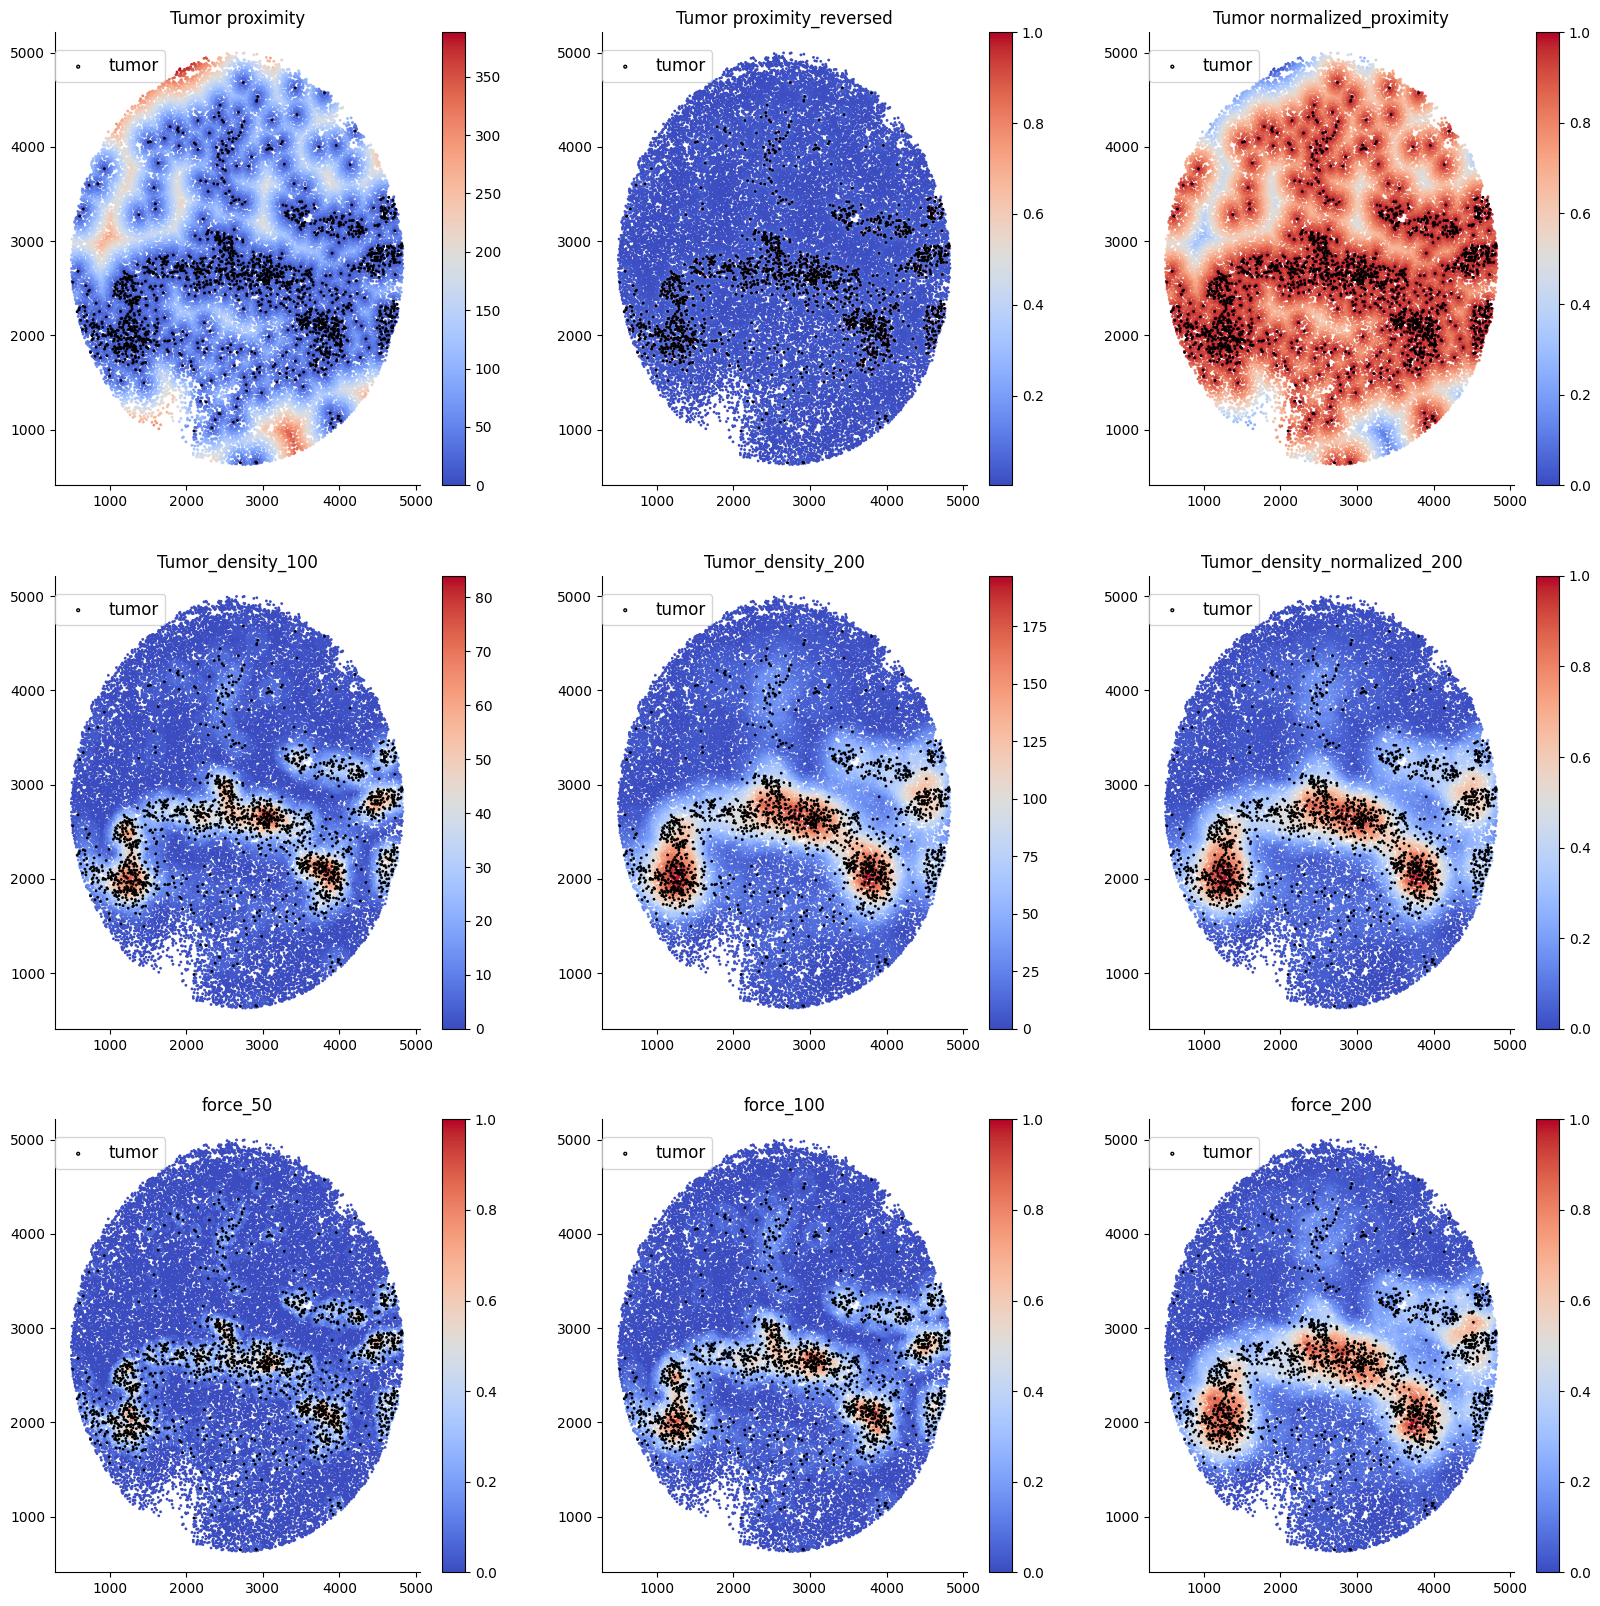

In [20]:
adata_tumor=adata[adata.obs["HRS_location"]==True]
df=adata.obs
df_tumor=adata_tumor.obs
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

       
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["proximity"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


# Add title and labels
plt.title("Tumor proximity", fontsize=12)
plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)

# Add legend
# Show plot

plt.subplot(3,3,2)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

        

plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["proximity_reversed"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
plt.title("Tumor proximity_reversed", fontsize=12)

plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)
    #plt.savefig(save_path)  

plt.subplot(3,3,3)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

        

plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["proximity_minmax"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
plt.title("Tumor normalized_proximity", fontsize=12)

plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)
    #plt.savefig(save_path) 

adata_tumor=adata[adata.obs["HRS_location"]==True]
df=adata.obs
df_tumor=adata_tumor.obs
plt.subplot(3,3,4)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

       
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["density_100"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


# Add title and labels
plt.title("Tumor_density_100", fontsize=12)
plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)

# Add legend
# Show plot

plt.subplot(3,3,5)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

        

plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["density_200"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
plt.title("Tumor_density_200", fontsize=12)

plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)
    #plt.savefig(save_path)  

plt.subplot(3,3,6)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

        

plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["density_normalized200"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
plt.title("Tumor_density_normalized_200", fontsize=12)

plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)
    #plt.savefig(save_path) 
plt.subplot(3,3,7)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

       
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["force_50"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


# Add title and labels
plt.title("force_50", fontsize=12)
plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)

# Add legend
# Show plot

plt.subplot(3,3,8)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

        

plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["force_100"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
plt.title("force_100", fontsize=12)

plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)
    #plt.savefig(save_path)  

plt.subplot(3,3,9)
plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=0.05, color="gray")

        

plt.scatter(df["xcoord"], df["ycoord"], s=1, alpha=1, c=df["force_200"], cmap="coolwarm")
plt.colorbar()
plt.scatter(df_tumor["xcoord"], df_tumor["ycoord"], s=1, alpha=1, facecolors="none", edgecolors="black", label="tumor")


        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
plt.title("force_200", fontsize=12)

plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)
    #plt.savefig(save_path) 
plt.show()
   

   
